In [10]:
import time

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, random, jacrev
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt

key = random.PRNGKey(seed=100)

In [11]:
def target_func(x):
    return x ** 2 + 10

In [12]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [1, 32, 32, 1]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [13]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = jnp.maximum(jnp.dot(w, activations) + b, 0)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    output = jnp.dot(final_w, activations) + final_b
    return output

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [14]:
def loss(params, train_x, train_y):
    pred_y = batch_forward(params, train_x)

    return jnp.mean(jnp.square(pred_y - train_y))

In [15]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

@jit
def update(params, train_x, train_y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, train_x, train_y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [16]:
train_loss = []

for epoch in range(10000):
    train_x = ((np.random.rand(1000)*20) - 10).reshape(-1, 1)
    train_y = target_func(train_x)

    params, opt_state, loss = update(params, train_x, train_y, opt_state)
    if epoch % 1000 == 0:
        print(loss)

    train_loss.append(loss)


2723.931
73.642845
52.362564
47.950245
38.99762
30.135115
17.176607
3.4315064
0.34353003
0.0834343


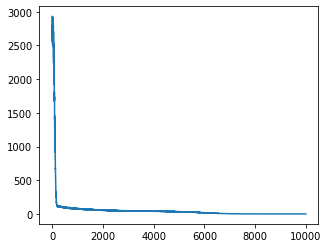

In [19]:
plt.figure(figsize = (5,4))
plt.plot(train_loss)
plt.show()

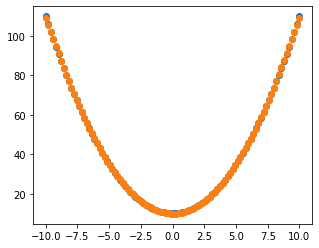

In [20]:
test_x = jnp.linspace(start=-10, stop=10, num=100).reshape(-1, 1)
test_y = target_func(test_x)
pred_y = batch_forward(params, test_x)

plt.figure(figsize = (5,4))
plt.scatter(test_x, test_y)
plt.scatter(test_x, pred_y)
plt.show()